Saving cure_the_princess_validation.csv to cure_the_princess_validation (22).csv
Saving cure_the_princess_test.csv to cure_the_princess_test (22).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (22).csv
Epoch 1/50, Train Loss: 0.6915, Val Loss: 0.6872
Epoch 2/50, Train Loss: 0.6912, Val Loss: 0.6867
Epoch 3/50, Train Loss: 0.6950, Val Loss: 0.6862
Epoch 4/50, Train Loss: 0.6958, Val Loss: 0.6858
Epoch 5/50, Train Loss: 0.6990, Val Loss: 0.6853
Epoch 6/50, Train Loss: 0.6964, Val Loss: 0.6848
Epoch 7/50, Train Loss: 0.6886, Val Loss: 0.6843
Epoch 8/50, Train Loss: 0.6826, Val Loss: 0.6839
Epoch 9/50, Train Loss: 0.6929, Val Loss: 0.6834
Epoch 10/50, Train Loss: 0.6919, Val Loss: 0.6829
Epoch 11/50, Train Loss: 0.6889, Val Loss: 0.6825
Epoch 12/50, Train Loss: 0.6947, Val Loss: 0.6821
Epoch 13/50, Train Loss: 0.6917, Val Loss: 0.6816
Epoch 14/50, Train Loss: 0.6824, Val Loss: 0.6812
Epoch 15/50, Train Loss: 0.6862, Val Loss: 0.6807
Epoch 16/50, Train Loss: 0.6907, Val L

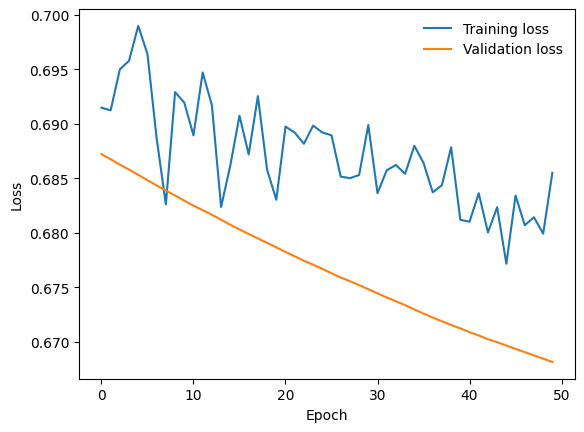

Geçen süre: 14.5119 saniye


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import time

start = time.time()
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2) # Dropout katmanı ekle
        self.regularization = nn.Linear(hidden_dim2, 1) # Regularizasyon katmanı ekle

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out) # Dropout'u ilk katmanın çıktısına uygula
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out) # Dropout'u ikinci katmanın çıktısına uygula
        out = self.fc3(out)
        out = self.sigmoid(out)
        reg_loss = 0 # Regularizasyon kaybını sıfırla
        for param in self.parameters():
            reg_loss += torch.norm(param) # Tüm ağırlıkların karelerinin toplamı
        return out + 0.001 * reg_loss # Regularizasyon kaybını toplam kayba ekle



 
# Train verilerinin yüklenmesi
uploaded = files.upload()
train_data = np.loadtxt(io.BytesIO(uploaded['cure_the_princess_train.csv']), delimiter=",", skiprows=1)
train_labels = train_data[:, -1]  # son sütunu etiketler olarak ayırın
train_data = train_data[:, :-1]   # son sütunu verilerden çıkarın

# Validation verilerinin yüklenmesi
 
val_data = np.loadtxt(io.BytesIO(uploaded['cure_the_princess_validation.csv']), delimiter=",", skiprows=1)
val_labels = val_data[:, -1]  # son sütunu etiketler olarak ayırın
val_data = val_data[:, :-1]   # son sütunu verilerden çıkarın


# Test verilerinin yüklenmesi
test_data = np.loadtxt(io.BytesIO(uploaded['cure_the_princess_test.csv']), delimiter=",", skiprows=1)
test_labels = test_data[:, -1]  # son sütunu etiketler olarak ayırın
test_data = test_data[:, :-1]   # son sütunu verilerden çıkarın

 
 

# Verilerin torch tensorlerine dönüştürülmesi
train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels).long()
val_data = torch.tensor(val_data).float()
val_labels = torch.tensor(val_labels).long()
test_data = torch.tensor(test_data).float()
test_labels = torch.tensor(test_labels).long() 
 

# MLP modelinin tanımlanması
input_dim = train_data.shape[1]
hidden_dim1 = 100
hidden_dim2 = 50
output_dim = len(torch.unique(train_labels))
mlp = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = train_data.to(device)
train_labels = train_labels.to(device)
val_data = val_data.to(device)
val_labels = val_labels.to(device)
test_data = test_data.to(device)
test_labels = test_labels.to(device)

mlp = mlp.to(device)


# Eğitim parametrelerinin belirlenmesi
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate, weight_decay=0.001) # L2 regularizasyonu ekleyin

# Random seed'in belirlenmesi
SEED = 180401122
torch.manual_seed(SEED)

# Eğitim epoch sayısının belirlenmesi
n_epochs = 50

# Eğitim ve validasyon loss'larının kaydedilmesi için listelerin tanımlanması
train_losses = []
val_losses = []

# Eğitim döngüsü
for epoch in range(n_epochs):
    # MLP'nin eğitimi
    mlp.train()
    optimizer.zero_grad()
    train_outputs = mlp(train_data)
    train_loss = criterion(train_outputs, train_labels)
    train_loss.backward()
    optimizer.step()

    # Eğitim ve validasyon loss'larının kaydedilmesi
    train_losses.append(train_loss.item())
    with torch.no_grad():
        mlp.eval()
        val_outputs = mlp(val_data)
        val_loss = criterion(val_outputs, val_labels)
        val_losses.append(val_loss.item())

 
    # Her epoch'ta eğitim ve validasyon loss'larının ekrana yazdırılması
    print('Epoch %d/%d, Train Loss: %.4f, Val Loss: %.4f' % (epoch+1, n_epochs, train_loss.item(), val_loss.item()))


def test_model(model, test_data, test_labels):
    model.eval()
    test_outputs = model(test_data)
    test_loss = criterion(test_outputs, test_labels)
    _, predicted = torch.max(test_outputs, 1)
    correct = (predicted == test_labels).sum().item()
    accuracy = 100 * correct / len(test_labels)
    precision = 100 * correct / predicted.shape[0]
    recall = 100 * correct / test_labels.shape[0]
    f1_score = 2 * precision * recall / (precision + recall)
    print('Test set results - Loss: %.4f, Accuracy: %.4f%%, Precision: %.4f%%, Recall: %.4f%%, F1-score: %.4f%%'
          % (test_loss.item(), accuracy, precision, recall, f1_score))
    return test_loss, accuracy, precision, recall, f1_score

# # En iyi modelin yüklenmesi
# best_model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)
# best_model.load_state_dict(torch.load('best_model.pt'))


# Test setinde modelin performansının test edilmesi
test_model(mlp, test_data, test_labels)



#Eğitim ve validasyon loss'larının figürde gösterilmesi
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
 
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss') 
 
plt.show()

end = time.time()
print('Geçen süre: %.4f saniye' % (end - start))